<a href="https://colab.research.google.com/github/terezaluskova/EEICT2025/blob/main/Code_EEICT_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift detection in metabolomics-based predictions under cold-stress conditions in plants

In this script, we will focus on concept drift detection in metabolomics data for a paper at EEICT 2025.

In recent years, there has been a significant surge in the use of prediction models. These models typically assume that input data is stationary; however, much of the data we encounter is dynamic in nature. Among the most dynamic data are metabolomics, which change over time. One common challenge with time-varying data is the occurrence of concept drift. Concept drift can degrade the accuracy and reliability of prediction models, making it a key issue to address. Despite its negative impact, concept drift can also be leveraged to uncover hidden confounding factors in the data. The main goal of this study is to detect concept drift in metabolite concentrations across different ecotypes of Arabidopsis thaliana under varying growth conditions. The study is divided into two parts: first, we apply different predictive regressors to metabolomic data, and second, we use these models to detect concept drift. Our focus lies in identifying potential confounding factors that may influence the prediction of relative growth rates in plants.




# Installation required packages and repositories

In [95]:
!pip install scikit-learn
!pip install numpy scipy scikit-learn
!pip install scikit-multiflow==0.4.0

In [96]:
# Google Colab

from google.colab import files

# Data Handling
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model Selection and Validation
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Drift Detection (for streaming data)
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import EDDM

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Connecting to Google Disk and Loading data

In [97]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [98]:
#_______________________________________________________________________________
#
# Loading data
#_______________________________________________________________________________
#

# Here you can put yourself working directory:
# url = ...

#_______________________________________________________________________________
# Our example data / you can find in github "example data" or supplementary
# materials

#
# Concentration data measured at 6 °C from study Weiszmann et al.
data_6_concentration = "/content/drive/MyDrive/Concept_Drift_Detection_in_Metabolomics_Data/Metabolites_Ath_6C.xlsx"
# Concentration data measured at 16 °C from study Weiszmann et al.
data_16_concentration = "/content/drive/MyDrive/Concept_Drift_Detection_in_Metabolomics_Data/Metabolites_Ath_16C.xlsx"
# Relative growth rate data measured at 6 °C from study Weiszmann et al.
data_6_relative_growth_rate = "/content/drive/MyDrive/Concept_Drift_Detection_in_Metabolomics_Data/Phenotype_Ath_RGR_6.xlsx"
# Relative growth rate data measured at 16 °C from study Weiszmann et al.
data_16_relative_growth_rate = "/content/drive/MyDrive/Concept_Drift_Detection_in_Metabolomics_Data/Phenotype_Ath_RGR_16.xlsx"


In [99]:
data_6_degree = pd.read_excel(data_6_concentration, header=None)
data_16_degree = pd.read_excel(data_16_concentration, header=None)

output_data_6_degree = pd.read_excel(data_6_relative_growth_rate, header=None)
output_data_16_degree= pd.read_excel(data_16_relative_growth_rate, header=None)


# Data distribution

In [101]:
# Metabolite and ecotype names
ecotypes = data_6_degree.iloc[1:, 0].astype(str).apply(lambda x: x.split(',')[0]).tolist()
metabolites = data_6_degree.iloc[0, 0].split(',')[1:]
sugar = {'Maltose', 'Fructose', 'Galactose', 'Glucose'}

# ----------------------------------------------
# Extract data for 6 °C
#-----------------------------------------------

# Initialize list to hold values for 6 °C
values_6_degree = []

# Loop through each row and extract values for 6 °C
for row in data_6_degree.iloc[1:, 0]:
    row_values = row.split(',')[1:]
    for value in row_values:
        values_6_degree.append(float(value.strip()))

# Convert the list to a numpy array and reshape
data_array_6_degree = np.array(values_6_degree)
data_array_6_degree = data_array_6_degree.reshape(-1, len(row_values))

# ----------------------------------------------
# Extract output data for 6 °C
#-----------------------------------------------

# Initialize list to hold output data values for 6 °C
values_6_degree_output = []

# Loop through each row and extract values for output data 6 °C
for row in output_data_6_degree.iloc[1:, 0]:
    row_values = row.split(',')[1:]
    for value in row_values:
        values_6_degree_output.append(float(value.strip()))

# Convert the list to a numpy array and reshape
output_data_array_6_degree = np.array(values_6_degree_output)
output_data_array_6_degree = output_data_array_6_degree.reshape(-1, len(row_values))

# ----------------------------------------------
# Extract data for 16 °C
#-----------------------------------------------

# Initialize list to hold values for 16 °C
values_16_degree = []

# Loop through each row and extract values for 16 °C
for row in data_16_degree.iloc[1:, 0]:
    row_values = row.split(',')[1:]
    for value in row_values:
        values_16_degree.append(float(value.strip()))

# Convert the list to a numpy array and reshape
data_array_16_degree = np.array(values_16_degree)
data_array_16_degree = data_array_16_degree.reshape(-1, len(row_values))

# ----------------------------------------------
# Extract output data for 16 °C
#-----------------------------------------------

# Initialize list to hold output data values for 16 °C
values_16_degree_output = []

# Loop through each row and extract values for output data 16 °C
for row in output_data_16_degree.iloc[1:, 0]:
    row_values = row.split(',')[1:]
    for value in row_values:
        values_16_degree_output.append(float(value.strip()))

# Convert the list to a numpy array and reshape
output_data_array_16_degree = np.array(values_16_degree_output)
output_data_array_16_degree = output_data_array_16_degree.reshape(-1, len(row_values))

# -----------------------------------------------------------------------------------
# Extract data without 4 metabolites - maltose, fructose, galactose, glucose
# -----------------------------------------------------------------------------------

# Finding the indices to remove for sugars
indices_to_remove = []
for i, m in enumerate(metabolites):
    if m in sugar:
        indices_to_remove.append(i)

# Removing the corresponding metabolites from the list
metabolites_33 = []
for i, m in enumerate(metabolites):
    if i not in indices_to_remove:
        metabolites_33.append(m)

# Removing the corresponding columns from the data array for 6 °C
data_33_metabolites_for_6 = np.delete(data_array_6_degree, indices_to_remove, axis=1)

# Removing the corresponding columns from the data array for 16 °C
data_33_for_16 = np.delete(data_array_16_degree, indices_to_remove, axis=1)

# -----------------------------------------------------------------------------------
# Extract data for 4 metabolites - maltose, fructose, galactose, glucose
# -----------------------------------------------------------------------------------

# Finding the indices to keep for sugars
indices_to_keep = []
for i, m in enumerate(metabolites):
    if m in sugar:
        indices_to_keep.append(i)

# Creating a list of metabolites to keep
metabolites_sugar = []

for i in indices_to_keep:
    metabolites_sugar.append(metabolites[i])

# Selecting the corresponding columns from the data array for 6°C
data_4_for_6 = data_array_6_degree[:, indices_to_keep]

# Selecting the corresponding columns from the data array for 16°C
data_4_for_16 = data_array_16_degree[:, indices_to_keep]

# Vykreslení subplotů

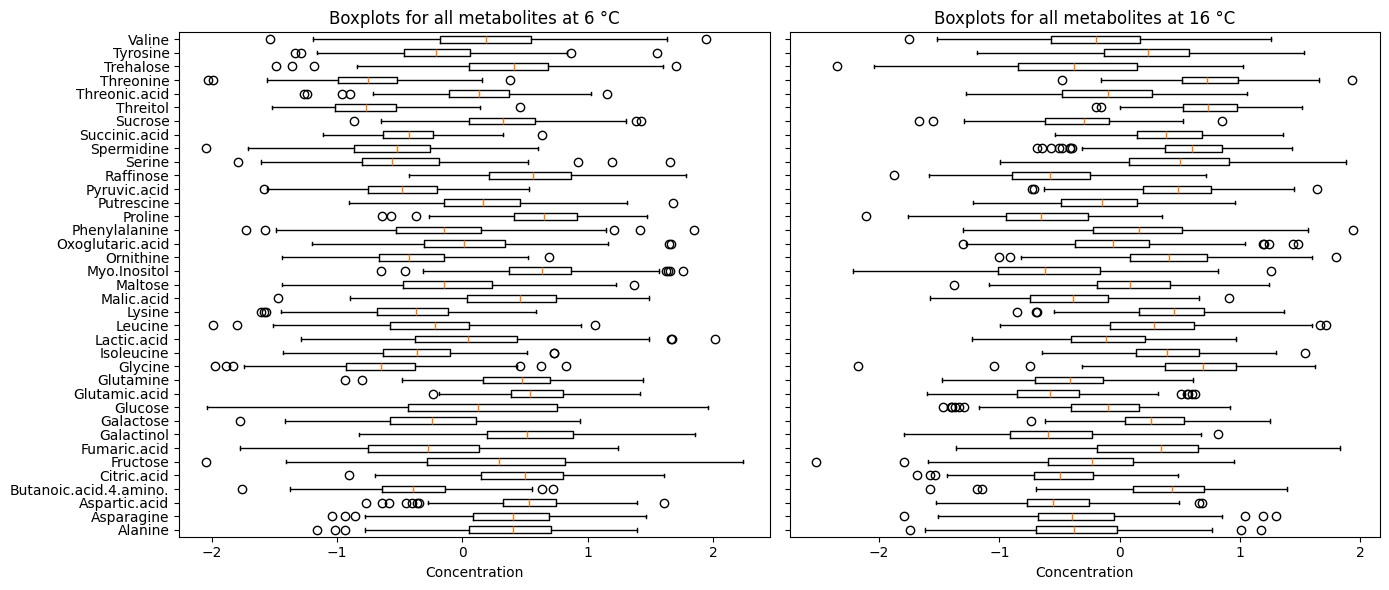

In [104]:
# Create subplots for two boxplots, one for each temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Boxplot for metabolites at 6°C
axes[0].boxplot(data_array_6_degree, vert=False)
axes[0].set_title('Boxplots for all metabolites at 6 °C')
axes[0].set_yticks(range(1, len(metabolites) + 1))
axes[0].set_yticklabels(metabolites)
axes[0].set_xlabel('Concentration')

# Boxplot for metabolites at 16°C
axes[1].boxplot(data_array_16_degree, vert=False)
axes[1].set_title('Boxplots for all metabolites at 16 °C')
axes[1].set_yticks(range(1, len(metabolites) + 1))
axes[1].set_yticklabels(metabolites)
axes[1].set_xlabel('Concentration')

# Adjust layout for better visualization
plt.tight_layout()

# Display the plots
plt.show()

# Data Preparation

In [ ]:
# Prepare data for 6°C
X_6_degree = data_33_metabolites_for_6.copy()
y_6_degree = output_data_array_6_degree.ravel()

# Prepare data for 16 °C
X_16_degree = data_33_for_16.copy()
y_16_degree = output_data_array_16_degree.ravel()

# Convert data to DataFrame for easier manipulation
X_6_degree_df = pd.DataFrame(X_6_degree)
X_16_degree_df = pd.DataFrame(X_16_degree)

# Align columns for datasets with common features
common_columns = X_6_degree_df.columns.intersection(X_16_degree_df.columns)
X_6_degree_common = X_6_degree_df[common_columns]
X_16_degree_common = X_16_degree_df[common_columns]

# Convert DataFrame back to numpy arrays for model training
X_6_degree_common = X_6_degree_common.to_numpy()
X_16_degree_common = X_16_degree_common.to_numpy()

# Combine the datasets for 6°C and 16°C
X_combined = np.vstack((X_6_degree_common, X_16_degree_common))
y_combined = np.concatenate((y_6_degree, y_16_degree))

# Model Evaluation with Cross-Validation

In [ ]:
# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize models
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_LR = LinearRegression()
model_SVR = SVR(kernel='rbf')

# Store models in a dictionary for easy reference
models = {
    "Random Forest Regressor": model_RF,
    "Linear Regression": model_LR,
    "Support Vector Regression": model_SVR
}

# ----------------------------------------------------
# Function to evaluate models using cross-validation
#-----------------------------------------------------

def evaluate_model(model, X, y, cv=10, tolerance=0.01):
    # Predict using cross-validation
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # Calculate evaluation metrics
    accuracy = np.mean(np.abs(y - y_pred) / y < tolerance)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    smape = np.mean(2 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred))) * 100

    return [accuracy, r2, mae, mse, rmse, smape]

# Concept Drift Detection Using DDM and EDDM

In [112]:

# ----------------------------------------------------
# Function for Concept Drift Detection using DDM
#-----------------------------------------------------

def detect_drift_ddm(predictions, classifier_name):
    drift_indices = []
    ddm = DDM()  # Initialize DDM for drift detection
    print(f"Concept drift detection (DDM) applied on {classifier_name} classifier:")

    for i, pred in enumerate(predictions):
        ddm.add_element(pred)
        if ddm.detected_warning_zone():
            print(f"Warning zone detected at index: {i}")
        if ddm.detected_change():
            print(f"Change detected at index: {i}")
            drift_indices.append(i)

    return drift_indices

# ----------------------------------------------------
# Function for Concept Drift Detection using EDDM
#-----------------------------------------------------

def detect_drift_eddm(predictions, classifier_name):
    drift_indices = []
    eddm = EDDM()  # Initialize EDDM for drift detection
    print(f"Concept drift detection (EDDM) applied on {classifier_name} classifier:")

    for i, pred in enumerate(predictions):
        eddm.add_element(pred)
        if eddm.detected_warning_zone():
            print(f"Warning zone detected at index: {i}")
        if eddm.detected_change():
            print(f"Change detected at index: {i}")
            drift_indices.append(i)

    return drift_indices

# ----------------------------------------------
# Results for combined dataset (6°C + 16°C)
#-----------------------------------------------

results_combined = []
detected_drift_ddm_combined = []
detected_drift_eddm_combined = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} on combined dataset")
    model.fit(X_combined, y_combined)
    results_combined.append([name] + evaluate_model(model, X_combined, y_combined))

    # Predict using cross-validation
    y_pred_combined = cross_val_predict(model, X_combined, y_combined, cv=kf)

    # Detect drift using DDM and EDDM
    drift_ddm_indices_combined = detect_drift_ddm(y_pred_combined, name)
    drift_eddm_indices_combined = detect_drift_eddm(y_pred_combined, name)

    detected_drift_ddm_combined.append(drift_ddm_indices_combined)
    detected_drift_eddm_combined.append(drift_eddm_indices_combined)

# Display results for combined data
df_results_combined = pd.DataFrame(results_combined, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for Combined Dataset (6°C + 16°C):")
print(df_results_combined)

print("\nDetected Drift Indices (DDM):")
print(detected_drift_ddm_combined)

print("\nDetected Drift Indices (EDDM):")
print(detected_drift_eddm_combined)

# ----------------------------------------------
# Results for 6°C predictions
#-----------------------------------------------

print("\nPrediction for 6°C")
results_6 = []
detected_drift_ddm_6 = []
detected_drift_eddm_6 = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} for 6°C prediction")
    model.fit(X_6_degree, y_6_degree)
    y_pred_6 = model.predict(X_6_degree)
    results_6.append([name] + evaluate_model(model, X_6_degree, y_6_degree))

    # Detect drift using DDM and EDDM
    drift_ddm_indices_6 = detect_drift_ddm(y_pred_6, name)
    drift_eddm_indices_6 = detect_drift_eddm(y_pred_6, name)

    detected_drift_ddm_6.append(drift_ddm_indices_6)
    detected_drift_eddm_6.append(drift_eddm_indices_6)

# Display results for 6°C
df_results_6 = pd.DataFrame(results_6, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 6°C Prediction:")
print(df_results_6)

print("\nDetected Drift Indices (DDM):")
print(detected_drift_ddm_6)

print("\nDetected Drift Indices (EDDM):")
print(detected_drift_eddm_6)

# ----------------------------------------------
# Results for 16°C predictions
#-----------------------------------------------

print("\nPrediction for 16°C")
detected_drift_ddm_16 = []
detected_drift_eddm_16 = []
results_16 = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} for 16°C prediction")
    model.fit(X_16_degree, y_16_degree)
    y_pred_16 = model.predict(X_16_degree)
    results_16.append([name] + evaluate_model(model, X_16_degree, y_16_degree))

    # Detect drift using DDM and EDDM
    drift_ddm_indices_16 = detect_drift_ddm(y_pred_16, name)
    drift_eddm_indices_16 = detect_drift_eddm(y_pred_16, name)

    detected_drift_ddm_16.append(drift_ddm_indices_16)
    detected_drift_eddm_16.append(drift_eddm_indices_16)

# Display results for 16°C
df_results_16 = pd.DataFrame(results_16, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 16°C Prediction:")
print(df_results_16)

print("\nDetected Drift Indices (DDM):")
print(detected_drift_ddm_16)

print("\nDetected Drift Indices (EDDM):")
print(detected_drift_eddm_16)


# ----------------------------------------------
# Results for predictions from 6°C to 16°C
#-----------------------------------------------

print("\nPrediction from 6°C to 16°C")
detected_drift_ddm_6_to_16 = []
detected_drift_eddm_6_to_16 = []
results_6_to_16 = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} for 6°C → 16°C prediction")
    model.fit(X_6_degree, y_6_degree)
    y_pred_6_to_16 = model.predict(X_16_degree)
    results_6_to_16.append([name] + evaluate_model(model, X_16_degree, y_16_degree))

    # Detect drift using DDM and EDDM
    drift_ddm_indices_6_to_16 = detect_drift_ddm(y_pred_6_to_16, name)
    drift_eddm_indices_6_to_16 = detect_drift_eddm(y_pred_6_to_16, name)

    detected_drift_ddm_6_to_16.append(drift_ddm_indices_6_to_16)
    detected_drift_eddm_6_to_16.append(drift_eddm_indices_6_to_16)

# Display results from 6°C to 16°C data
df_results_6_to_16 = pd.DataFrame(results_6_to_16, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 6°C → 16°C Prediction:")
print(df_results_6_to_16)

print("\nDetected Drift Indices (DDM):")
print(detected_drift_ddm_6_to_16)

print("\nDetected Drift Indices (EDDM):")
print(detected_drift_eddm_6_to_16)

# ----------------------------------------------
# Results for predictions from 16°C to 6°C
#-----------------------------------------------

print("\nPrediction from 16°C to 6°C")
detected_drift_ddm_16_to_6 = []
detected_drift_eddm_16_to_6 = []
results_16_to_6 = []

for name, model in models.items():
    print(f"\nEvaluating model: {name} for 16°C → 6°C prediction")
    model.fit(X_16_degree, y_16_degree)
    y_pred_16_to_6 = model.predict(X_6_degree)
    results_16_to_6.append([name] + evaluate_model(model, X_6_degree, y_6_degree))

    # Detect drift using DDM and EDDM
    drift_ddm_indices_16_to_6 = detect_drift_ddm(y_pred_16_to_6, name)
    drift_eddm_indices_16_to_6 = detect_drift_eddm(y_pred_16_to_6, name)

    detected_drift_ddm_16_to_6.append(drift_ddm_indices_16_to_6)
    detected_drift_eddm_16_to_6.append(drift_eddm_indices_16_to_6)

# Display results from 16°C to 6°C data
df_results_16_to_6 = pd.DataFrame(results_16_to_6, columns=["Model", "Accuracy", "R²", "MAE", "MSE", "RMSE", "SMAPE"])
print("\nResults for 16°C → 6°C Prediction:")
print(df_results_16_to_6)

print("\nDetected Drift Indices (DDM):")
print(detected_drift_ddm_16_to_6)

print("\nDetected Drift Indices (EDDM):")
print(detected_drift_eddm_16_to_6)



Evaluating model: Random Forest Regressor on combined dataset
Concept drift detection (DDM) applied on Random Forest Regressor classifier:
Warning zone detected at index: 274
Warning zone detected at index: 275
Warning zone detected at index: 276
Warning zone detected at index: 277
Warning zone detected at index: 278
Warning zone detected at index: 279
Warning zone detected at index: 280
Warning zone detected at index: 281
Warning zone detected at index: 282
Warning zone detected at index: 283
Warning zone detected at index: 284
Warning zone detected at index: 285
Warning zone detected at index: 286
Warning zone detected at index: 287
Warning zone detected at index: 288
Warning zone detected at index: 289
Warning zone detected at index: 290
Warning zone detected at index: 291
Warning zone detected at index: 292
Warning zone detected at index: 293
Warning zone detected at index: 294
Warning zone detected at index: 295
Warning zone detected at index: 296
Warning zone detected at index: 

# Results of metabolite concentration analysis after concept drift detection

In [125]:
# Combine data for 6°C and 16°C
combine_data_sugar = np.concatenate((data_4_for_6, data_4_for_16))
ecotype = np.concatenate((ecotypes, ecotypes))
def process_sugar_concentration_ddm(sugar, indices, data, ecotyp):
    """
    This function processes and prints the concentration of metabolites
    detected by the DDM concept drift method for specific indices.

    Args:
    - sugar: List of metabolites (sugar types) for which we are checking concentrations.
    - indices: Indices where concept drift is detected.
    - data: The actual data containing metabolite concentrations.
    - ecotyp: The ecotype associated with each data point.
    """
    concentrations = []

    for j, name in enumerate(sugar):
        metabolite_concentrations = []
        for i in range(len(indices)):
            if indices[i]: # Check if any drift indices exist
                for idx in indices[i]:
                    if idx > 0: # Ensure index is positive
                        print(f"Koncentrace metabolitu {sugar[j]} na indexu: {indices[i]}, hodnota: {data[i][j]}, ekotyp: {ecotype[i]}")
                        metabolite_concentrations.append(data[i][j])
            else:
                continue # Skip if no indices are present
    return concentrations

# Function to handle sugar concentration for EDDM drift detection
def process_sugar_concentration_eddm(sugar, indices, data, ecotyp):
    """
    This function processes and prints the concentration of metabolites
    detected by the EDDM concept drift method for specific indices.

    Args:
    - sugar: List of metabolites (sugar types) for which we are checking concentrations.
    - indices: Indices where concept drift is detected.
    - data: The actual data containing metabolite concentrations.
    - ecotyp: The ecotype associated with each data point.
    """
    for j, name in enumerate(sugar):
        for i in range(len(indices)):
            if indices[i]: # Check if any drift indices exist
                for idx in indices[i]:
                    if idx > 0: # Ensure index is positive
                        print(f"Koncentrace metabolitu {sugar[j]} na indexu: {indices[i]}, hodnota: {data[i][j]}, ekotyp: {ecotype[i]}")
            else:
                continue # Skip if no indices are present

# Display results for different datasets and drift detection
print("\nResults for Combined Dataset (6°C + 16°C):")
print("\nDetected drift indices (DDM):")
process_sugar_concentration_ddm(metabolites_sugar, detected_drift_indices_combined_ddm, combine_data_sugar, ecotype)
process_sugar_concentration_eddm(metabolites_sugar, detected_drift_indices_combined_eddm, combine_data_sugar, ecotype)

print("\nResults for 6°C Prediction:")
print("\nDetected drift indices (DDM):")
process_sugar_concentration_ddm(metabolites_sugar, detected_drift_indices_6_ddm, combine_data_sugar, ecotype)
print("\nDetected drift indices (EDDM):")
process_sugar_concentration_eddm(metabolites_sugar, detected_drift_indices_6_eddm, combine_data_sugar, ecotype)

print("\nResults for 16°C Prediction:")
print("\nDetected drift indices (DDM):")
process_sugar_concentration_ddm(metabolites_sugar, detected_drift_indices_16_ddm, combine_data_sugar, ecotype)
print("\nDetected drift indices (EDDM):")
process_sugar_concentration_eddm(metabolites_sugar, detected_drift_indices_16_eddm, combine_data_sugar, ecotype)

print("\nPrediction from 6°C to 16°C")
print("\nDetected drift indices (DDM):")
process_sugar_concentration_ddm(metabolites_sugar, detected_drift_indices_6_to_16_ddm, combine_data_sugar, ecotype)
print("\nDetected drift indices (EDDM):")
process_sugar_concentration_eddm(metabolites_sugar, detected_drift_indices_6_to_16_eddm, combine_data_sugar, ecotype)

print("\nPrediction from 16°C to 6°C")
print("\nDetected drift indices (DDM):")
process_sugar_concentration_ddm(metabolites_sugar, detected_drift_indices_16_to_6_ddm, combine_data_sugar, ecotype)
print("\nDetected drift indices (EDDM):")
process_sugar_concentration_eddm(metabolites_sugar, detected_drift_indices_16_to_6_eddm, combine_data_sugar, ecotype)

[[0.485, 1.069], [0.065, 0.262], [0.298, 0.761], [-0.895, 0.072]]

Results for Combined Dataset (6°C + 16°C):

Detected drift indices (DDM):
Koncentrace metabolitu Fructose na indexu: [324], hodnota: 0.485030315, ekotyp: 6C_410
Koncentrace metabolitu Fructose na indexu: [325], hodnota: 1.069109302, ekotyp: 6C_428
Koncentrace metabolitu Galactose na indexu: [324], hodnota: 0.065335445, ekotyp: 6C_410
Koncentrace metabolitu Galactose na indexu: [325], hodnota: 0.262664307, ekotyp: 6C_428
Koncentrace metabolitu Glucose na indexu: [324], hodnota: 0.29827073, ekotyp: 6C_410
Koncentrace metabolitu Glucose na indexu: [325], hodnota: 0.76120038, ekotyp: 6C_428
Koncentrace metabolitu Maltose na indexu: [324], hodnota: -0.895001212, ekotyp: 6C_410
Koncentrace metabolitu Maltose na indexu: [325], hodnota: 0.071596568, ekotyp: 6C_428

Results for 6°C Prediction:

Detected drift indices (DDM):

Detected drift indices (EDDM):

Results for 16°C Prediction:

Detected drift indices (DDM):

Detected dri

# Visualization of metabolite concentrations for 6°C and 16°C with concept drift detection

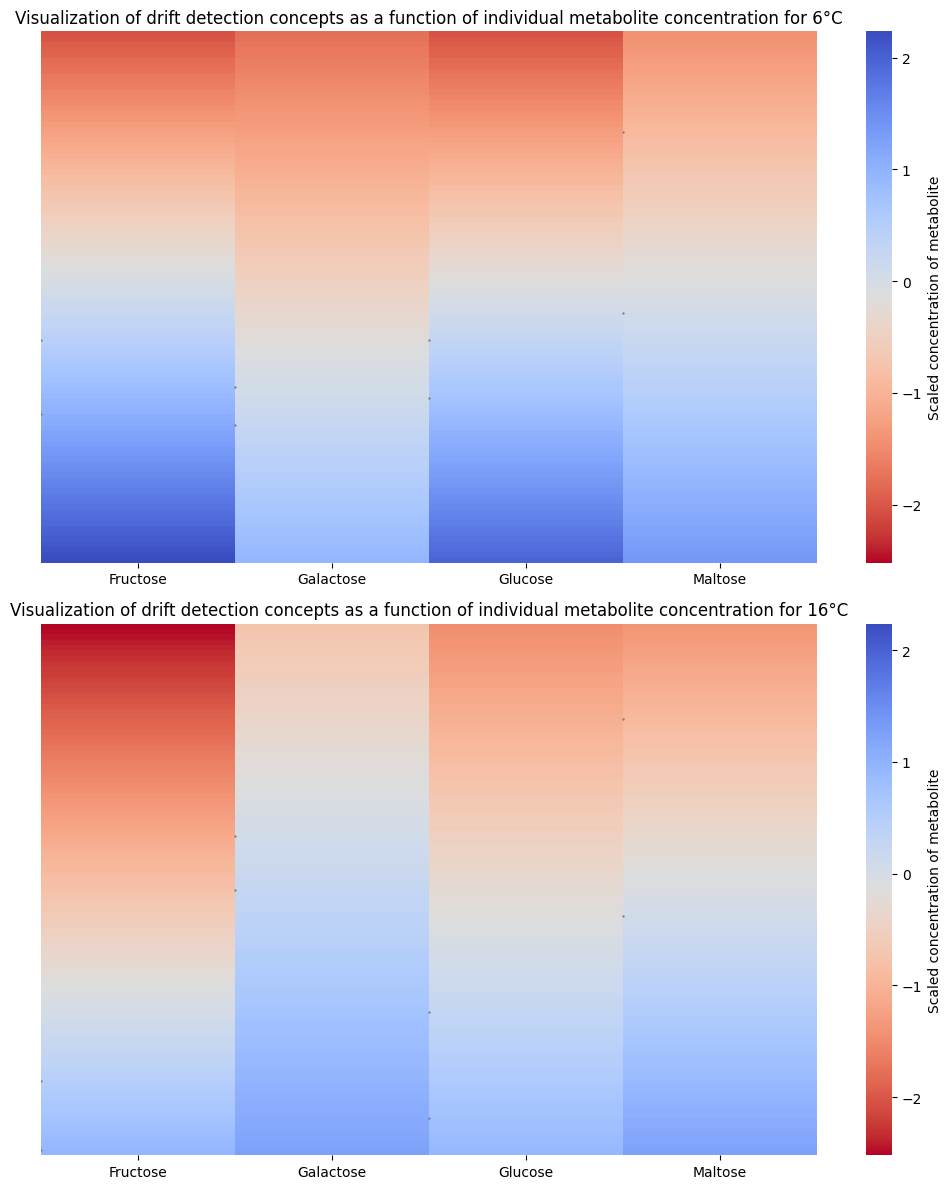

In [131]:
# ----------------------------------------------
# Heatmap for 6°C
# ----------------------------------------------

# Calculate minimum and maximum values for 6°C data
min_values_6 = np.min(data_4_for_6, axis=0)
max_values_6 = np.max(data_4_for_6, axis=0)

# Create a matrix of values between the minimum and maximum for each metabolite
matrix_for_6 = []
for min_val, max_val in zip(min_values_6, max_values_6):
    matrix_for_6.append(np.linspace(min_val, max_val, 100))

matrix_for_6 = np.array(matrix_for_6)

# ----------------------------------------------
# Heatmap for 16°C
# ----------------------------------------------

# Calculate minimum and maximum values for 16°C data
min_values_16 = np.min(data_4_for_16, axis=0)
max_values_16 = np.max(data_4_for_16, axis=0)

# Create a matrix of values between the minimum and maximum for each metabolite
matrix_for_16 = []
for min_val, max_val in zip(min_values_16, max_values_16):
    matrix_for_16.append(np.linspace(min_val, max_val, 100))

matrix_for_16 = np.array(matrix_for_16)

# Find the global minimum and maximum values across both heatmaps
global_min = min(np.min(matrix_for_6), np.min(matrix_for_16))
global_max = max(np.max(matrix_for_6), np.max(matrix_for_16))

# Plotting both heatmaps
plt.figure(figsize=(10, 12))

# 1st Heatmap (6°C)
plt.subplot(2, 1, 1)
sns.heatmap(
    matrix_for_6.T,
    cmap='coolwarm_r',
    xticklabels=metabolites_sugar,
    yticklabels=False,
    cbar_kws={'label': 'Scaled concentration of metabolite'},
    vmin=global_min, vmax=global_max
)
plt.title("Visualization of drift detection concepts as a function of individual metabolite concentration for 6°C")

# Plot concentrations for each metabolite on the heatmap for 6°C
for idx, metabolite in enumerate(metabolites_sugar):
    concs = concentrations[idx]  # Get concentrations for the current metabolite
    for conc in concs:
        # Find the closest index in the y-axis corresponding to the concentration value
        y_position = np.abs(np.linspace(min_values_6[idx], max_values_6[idx], 100) - conc).argmin()
        plt.scatter(idx, y_position, color='gray', s=00.5, zorder=10)

# 2nd Heatmap (16°C)
plt.subplot(2, 1, 2)
sns.heatmap(
    matrix_for_16.T,
    cmap='coolwarm_r',
    xticklabels=metabolites_sugar,
    yticklabels=False,
    cbar_kws={'label': 'Scaled concentration of metabolite'},
    vmin=global_min, vmax=global_max
)
plt.title("Visualization of drift detection concepts as a function of individual metabolite concentration for 16°C")

# Plot concentrations for each metabolite on the heatmap for 16°C
for idx, metabolite in enumerate(metabolites_sugar):
    concs = concentrations[idx]  # Get concentrations for the current metabolite
    for conc in concs:
        # Find the closest index in the y-axis corresponding to the concentration value
        y_position = np.abs(np.linspace(min_values_16[idx], max_values_16[idx], 100) - conc).argmin()
        plt.scatter(idx, y_position, color='gray', s=0.5, zorder=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()